---
**Code Testing**

Week 16 of EMAT30008

https://engmaths.github.io/emat30008/odes/codetesting/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# We import our functions from our own package
from scicomp.odefunctions import *

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


We find a key scientific error: inside of find_limit_cycle, our root finder tests out a limit cycle period which is less than the step size deltat_max

We need a way of restricting the domain which scipy.optimize.root tests over. There is no such way readily available after checking

This may present future problems but we convert the problem into a minimisation problem by establishing an objective function that sums the squares of all variables in G_collection and phi. We can then use bounded minimization solvers from scipy

In [2]:
# Testing changes

def shm(x, t):
    return np.array(([x[1], -x[0]]))

def ode_quick_plot(ode_func, init_state, t_final=200, step=0.1):
    # Just for quick testing, not rigorous
    solution = solve_to(ode_func, init_state, 0, t_final, step, 'RK4')

    plt.figure(figsize=[12,8])
    plt.scatter(solution[:,0], solution[:,1], c='r', marker='x', s=30, label='x(t)')
    plt.scatter(solution[:,0], solution[:,2], c='b', marker='x', s=30,label='y(t)', alpha=0.5)
    plt.legend()
    plt.title("State variables over time")
    plt.xlabel("Time")
    plt.ylabel("Variable value")
    plt.show()

    plt.figure(figsize=[12,8])
    plt.scatter(solution[:,1], solution[:,2], c='r', marker='x', s=10)
    plt.title("Phase space plot")
    plt.xlabel("Variable 1")
    plt.ylabel("Variable 2")
    plt.show()
    return None


A limit cycle was found:
Period: 12.57 ,
Starting state: [2.56, -0.0] .


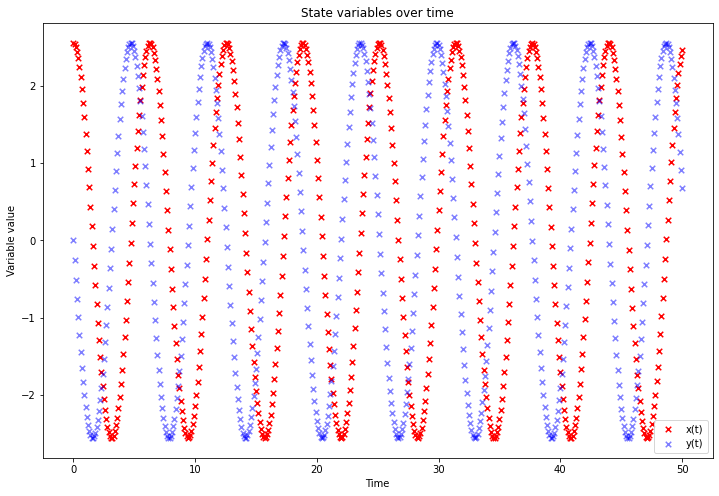

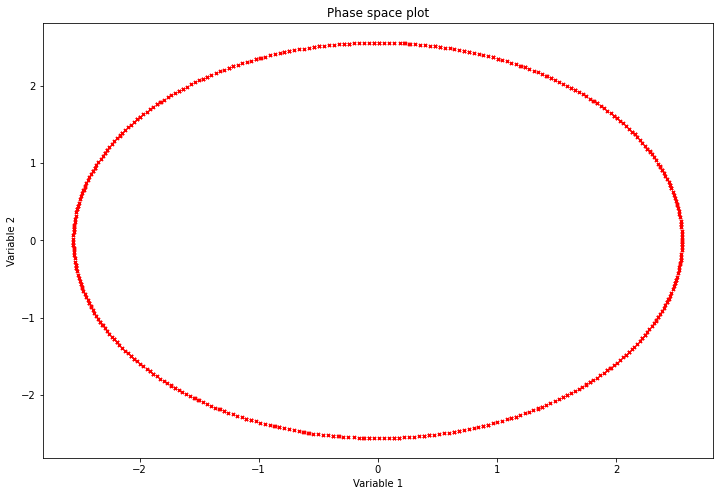

In [3]:
period, start_point = find_limit_cycle(shm, np.array(([5,1])), 10, 1)
ode_quick_plot(shm, start_point, 50)


------------
We now check against the Hopf bifurcation normal form

$\frac{d u_1}{dt} = \beta u_1 - u_2 + \sigma u_1 (u_1^2 + u_2^2)$

$\frac{d u_2}{dt} = u_1 + \beta u_2 + \sigma u_2 (u_1^2 + u_2^2)$

For $\sigma = -1$ we get the analytical solution
$u_1(t) = \sqrt{\beta} cos(t + \theta)$

$u_2(t) = \sqrt{\beta} cos(t + \theta)$

Where $\theta$ is the phase.


We search for a limit cycle, and test that this has a period of $2\pi$, and a start point with
euclidean magnitude $\beta$:


In [4]:
# Checking against hopf bifurcation normal form
def hopf_ode(x, t):
    beta = 2 # Chosen arbitrarily
    sigma = -1
    u1, u2 = x[0], x[1]
    du1dt = beta*u1 - u2 + sigma*u1*(u1**2 + u2**2)
    du2dt = u1 + beta*u2 + sigma*u2*(u1**2 + u2**2)
    return np.array(([du1dt, du2dt]))

# We then expect a period of 2pi from our limit cycle, and a magnitude of sqrt(Beta)
init_point_guess = np.array(([1,1]))
init_period_guess = 6 # Close to 2*pi=6.28

period, start_point = find_limit_cycle(hopf_ode, init_point_guess, init_period_guess)

if abs(period - 2*np.pi) < 1e-5:
    print("Test passed.")
else:
    print("Test failed.")

if abs(np.sqrt(2) - np.sqrt(np.sum(np.square(start_point))))<1e-5:
    print("Test passed.")
else:
    print("Test failed.")

#ode_quick_plot(hopf_ode, start_point, 50)

A limit cycle was found:
Period: 6.28 ,
Starting state: [1.41, 0.0] .
Test passed.
Test passed.


----------
We test against a non-autonomous ODE: Forced SHM

$\frac{d^2 x}{dt} = -x -\alpha \frac{dx}{dt} + \beta (1 + cos(\frac{2\pi t}{\gamma}))$

where $\alpha$ is the damping coefficient, $\beta$ the forcing amplitude and $\gamma$ the forcing period.

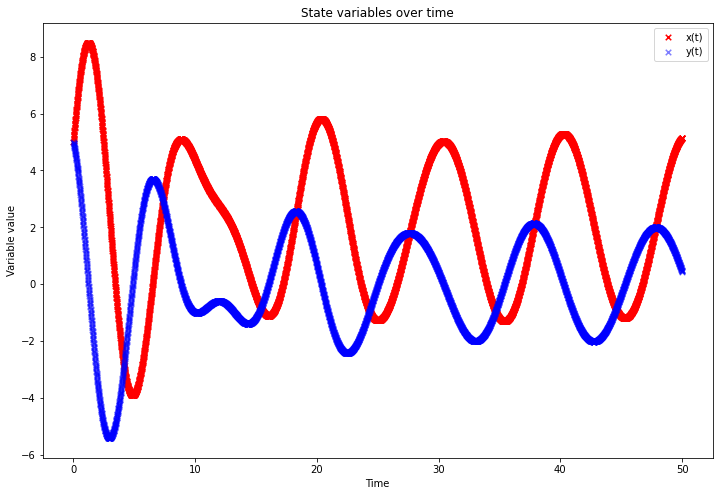

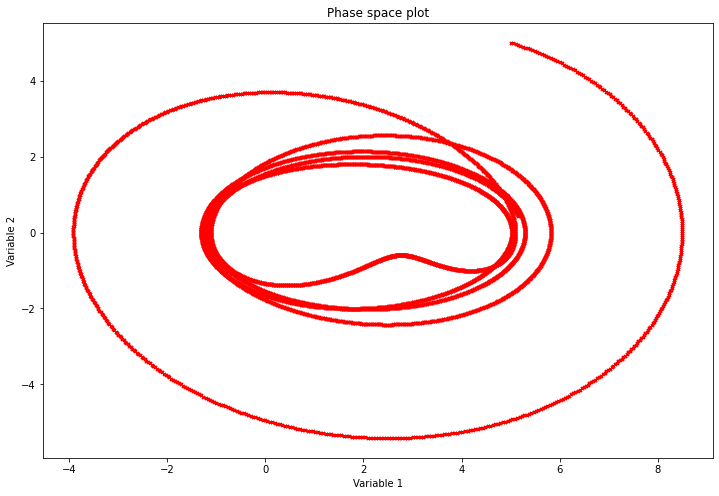

In [5]:
# Trying on SHM ode
def forced_shm(x,t):
    damping = 0.2
    forcing_amplitude = 2
    forcing_period = 10
    s = x[0]
    v = x[1]
    a = -s  + -damping*v + forcing_amplitude*(1+ np.cos(t*(2*np.pi)/forcing_period))
    return np.array(([v,a]))

# We plot this for a random initial condition.
ode_quick_plot(forced_shm, np.array(([5,5])), step=0.01, t_final=50)

# We expect a solution that tends towards a limit cycle

A limit cycle was found:
Period: 20.32 ,
Starting state: [5.18, 0.0] .


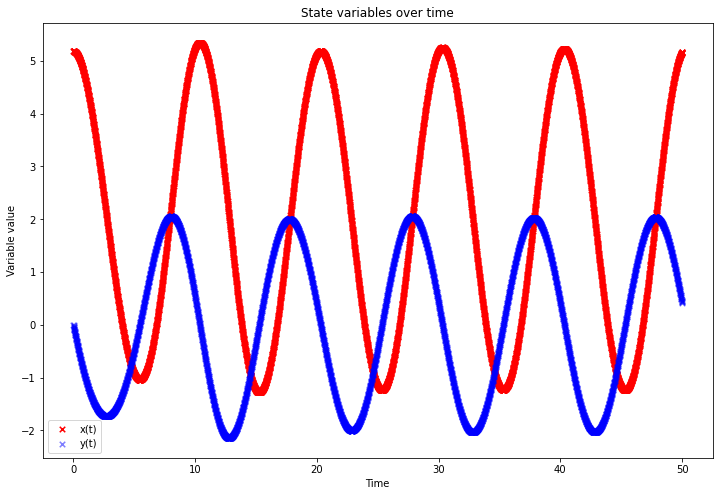

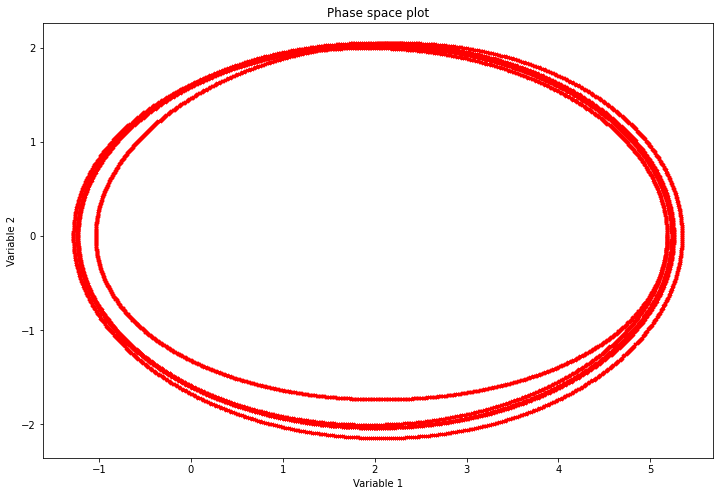

In [6]:
period, start_point = find_limit_cycle(forced_shm, np.array(([5,0])), 20, 1)
ode_quick_plot(forced_shm, start_point, t_final=50, step=0.01)

The code correctly identifies a limit cycle for the non-autonomouse ODE. The code is quite fragile to different initial guesses, and will often fall into equillibrium solutions

----------
We now test the code for throwing errors.

Start with when the dimensions for the initial condition and ode function don't match:

In [7]:
period, start_point = find_limit_cycle(forced_shm, np.array(([5,0,8])), 20, 1)

Exception: ODE function and initial condition dimensions do not match.

Test the case where no root is found

In [8]:
period, start_point = find_limit_cycle(hopf_ode, np.array(([12,-6])), 12, 3)


A limit cycle was found:
Period: 12.57 ,
Starting state: [1.41, 0.0] .


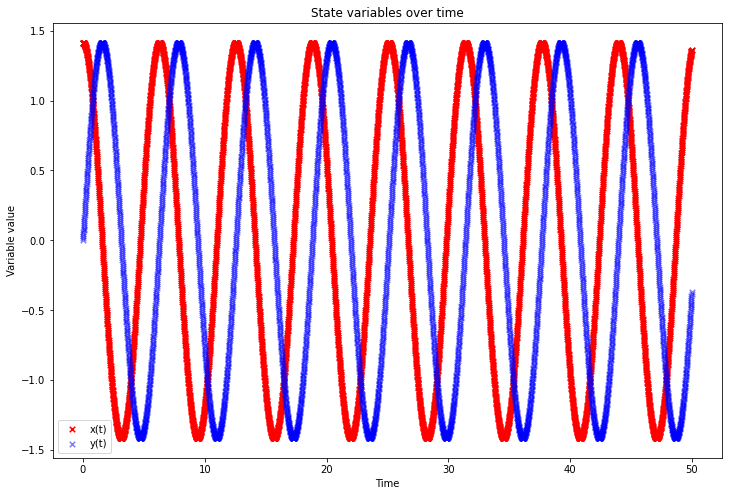

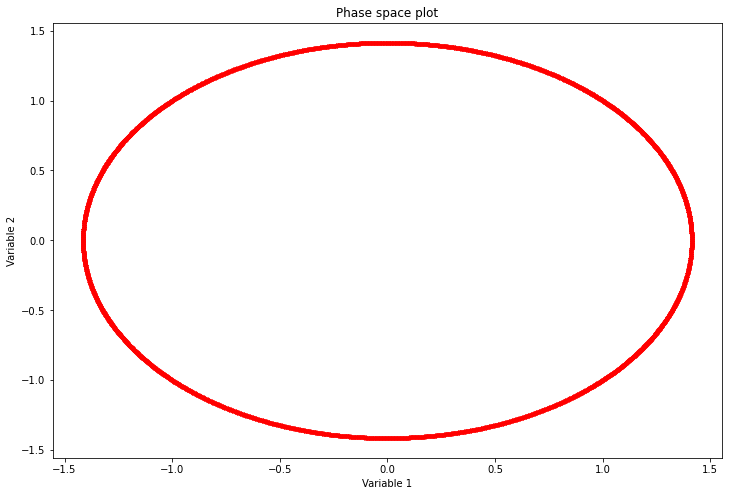

In [19]:
ode_quick_plot(hopf_ode, start_point, t_final=50, step=0.01)

Problems:
limit_cycle_condition isn't enough
- Fails and gives tiny periods 
- Gives multiples of other periods
doesn't seem to work for any initial conditions not near the right cycle
also reports success for things that aren't limit cycles

limit_cycle_condition needs overhaul


UPDATE:

Upon speaking to Matt he suggests I revert to basic root finding, let the wrong period throw errors and make the user do more work to find working periods

TODO: Rename existing functions as limit_cycle_condition_complex and find_limit_cycle_complex, and rewrite normal ones